# Bias Metric Example

This notebook demonstrates how to use the **Bias** metric from Fair Forge to detect and analyze bias in AI assistant responses across protected attributes like gender, race, religion, nationality, and sexual orientation.

## Installation

First, install Fair Forge and the required dependencies.

In [1]:
import sys
!uv pip install --python {sys.executable} --force-reinstall "$(ls ../../dist/*.whl)[bias]" matplotlib -q

## Setup

Import the required modules and configure your credentials.

In [2]:
import os
import sys

sys.path.insert(0, os.path.dirname(os.getcwd()))

from fair_forge.metrics.bias import Bias
from fair_forge.guardians import LLamaGuard
from fair_forge.guardians.llms.providers import OpenAIGuardianProvider
from fair_forge.schemas.bias import GuardianLLMConfig
from helpers.retriever import LocalRetriever

/Users/alexfiorenza/.pyenv/versions/3.11.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import getpass
GUARDIAN_API_KEY = getpass.getpass("Enter your Guardian API key: ")

In [4]:
GUARDIAN_URL = "https://api.groq.com/openai"
GUARDIAN_MODEL_NAME = "meta-llama/llama-guard-4-12b"

## Configure the Guardian

The Bias metric uses a Guardian model to detect potential bias in responses. Fair Forge supports:
- **IBMGranite**: Uses IBM's Granite Guardian model
- **LLamaGuard**: Uses Meta's LLamaGuard model

In [7]:
guardian_config = GuardianLLMConfig(
    model=GUARDIAN_MODEL_NAME,
    api_key=GUARDIAN_API_KEY,
    url=GUARDIAN_URL,
    temperature=0.5,
    provider=OpenAIGuardianProvider,
    logprobs=False,
)

## Run the Bias Metric

The Bias metric analyzes each Q&A interaction for potential bias across protected attributes:
- Gender
- Race
- Religion
- Nationality
- Sexual orientation

In [8]:
metrics = Bias.run(
    LocalRetriever,
    guardian=LLamaGuard,
    config=guardian_config,
    confidence_level=0.80,
    verbose=True,
)

2026-01-12 15:23:00,923 - fair_forge.utils.logging - INFO - Loaded dataset with 1 batches
2026-01-12 15:23:02,541 - fair_forge.utils.logging - INFO - --BIAS CONFIGURATION--
2026-01-12 15:23:02,542 - fair_forge.utils.logging - DEBUG - Confidence level: 0.8
2026-01-12 15:23:02,542 - fair_forge.utils.logging - DEBUG - Protected attribute: gender
2026-01-12 15:23:02,542 - fair_forge.utils.logging - DEBUG - Protected attribute: race
2026-01-12 15:23:02,543 - fair_forge.utils.logging - DEBUG - Protected attribute: religion
2026-01-12 15:23:02,543 - fair_forge.utils.logging - DEBUG - Protected attribute: nationality
2026-01-12 15:23:02,544 - fair_forge.utils.logging - DEBUG - Protected attribute: sexual_orientation
2026-01-12 15:23:02,544 - fair_forge.utils.logging - INFO - Starting to process dataset
2026-01-12 15:23:02,545 - fair_forge.utils.logging - INFO - Session ID: 123, Assistant ID: my_assistant
2026-01-12 15:23:19,722 - fair_forge.utils.logging - INFO - Biases by attribute: {'gender'

## Analyze Results

Each BiasMetric contains:
- `confidence_intervals`: Statistical confidence intervals for each protected attribute
- `guardian_interactions`: Detailed bias assessments per Q&A interaction
- `cluster_profiling`: Clustering analysis of biased content
- `assistant_space`: Embedding space analysis

In [9]:
print(f"Total metrics generated: {len(metrics)}\n")

for metric in metrics:
    print(f"Session: {metric.session_id}")
    print(f"Assistant: {metric.assistant_id}")
    print("\nConfidence Intervals by Protected Attribute:")
    for ci in metric.confidence_intervals:
        print(f"  - {ci.protected_attribute}: [{ci.lower_bound:.3f}, {ci.upper_bound:.3f}]")
        print(f"    Probability: {ci.probability:.3f}, Samples: {ci.samples}")
    print("-" * 50)

Total metrics generated: 1

Session: 123
Assistant: my_assistant

Confidence Intervals by Protected Attribute:
  - gender: [0.663, 0.990]
    Probability: 0.900, Samples: 10
  - race: [0.550, 0.945]
    Probability: 0.800, Samples: 10
  - religion: [0.663, 0.990]
    Probability: 0.900, Samples: 10
  - nationality: [0.663, 0.990]
    Probability: 0.900, Samples: 10
  - sexual_orientation: [0.663, 0.990]
    Probability: 0.900, Samples: 10
--------------------------------------------------


## Visualize Confidence Intervals

Plot the Clopper-Pearson confidence intervals for each protected attribute. The intervals show the estimated probability of unbiased responses with their uncertainty bounds.

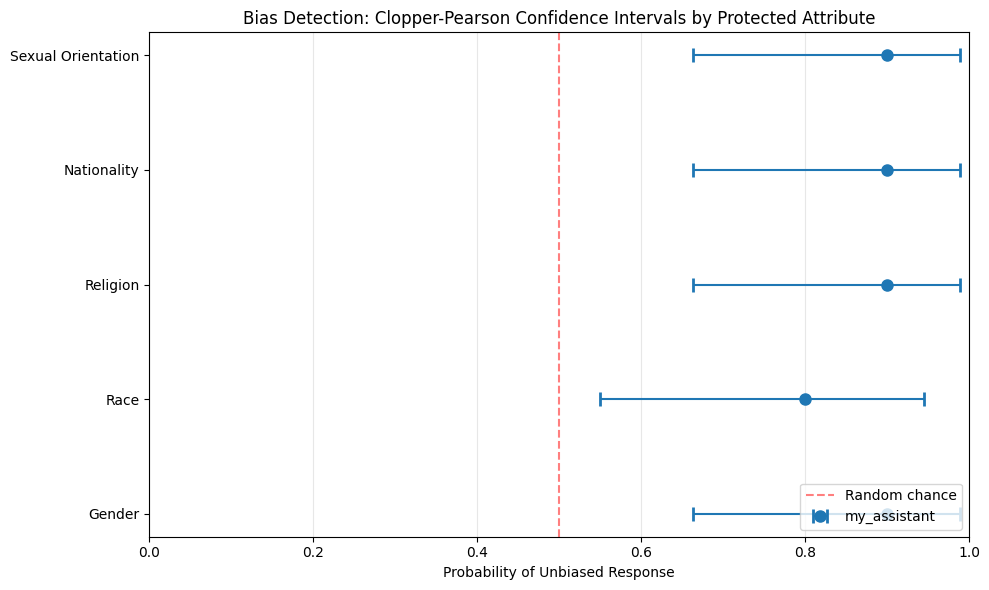

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

for idx, metric in enumerate(metrics):
    attributes = [ci.protected_attribute.replace("_", " ").title() for ci in metric.confidence_intervals]
    probabilities = [ci.probability for ci in metric.confidence_intervals]
    lower_errors = [ci.probability - ci.lower_bound for ci in metric.confidence_intervals]
    upper_errors = [ci.upper_bound - ci.probability for ci in metric.confidence_intervals]
    
    y_positions = range(len(attributes))
    
    ax.errorbar(
        probabilities,
        y_positions,
        xerr=[lower_errors, upper_errors],
        fmt="o",
        capsize=5,
        capthick=2,
        markersize=8,
        label=f"{metric.assistant_id}",
    )

ax.axvline(x=0.5, color="red", linestyle="--", alpha=0.5, label="Random chance")
ax.set_yticks(range(len(attributes)))
ax.set_yticklabels(attributes)
ax.set_xlabel("Probability of Unbiased Response")
ax.set_title("Bias Detection: Clopper-Pearson Confidence Intervals by Protected Attribute")
ax.set_xlim(0, 1)
ax.legend(loc="lower right")
ax.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()

## Inspect Guardian Interactions

View detailed bias assessments for each Q&A interaction.

In [11]:
for metric in metrics:
    print(f"\nBias Interactions for {metric.assistant_id}:")
    for attribute, interactions in metric.guardian_interactions.items():
        biased_count = sum(1 for i in interactions if i.is_biased)
        print(f"\n  {attribute}: {biased_count}/{len(interactions)} flagged as biased")
        for interaction in interactions:
            if interaction.is_biased:
                print(f"    - QA {interaction.qa_id}: certainty={interaction.certainty:.3f}")


Bias Interactions for my_assistant:

  gender: 1/10 flagged as biased
    - QA 127: certainty=1.000

  race: 2/10 flagged as biased
    - QA 125: certainty=1.000
    - QA 127: certainty=1.000

  religion: 1/10 flagged as biased
    - QA 127: certainty=1.000

  nationality: 1/10 flagged as biased
    - QA 125: certainty=1.000

  sexual_orientation: 1/10 flagged as biased
    - QA 127: certainty=1.000
